Implémentation du devoir 4

Lucca MASI MASL05080300

Problématique : comment créer un algorithme de machine learning permettant de prédire le cours des actions?

BDD : Sp500 (cour des actions global depuis le 3 Janv 19500 )

vidéo explicative : https://youtu.be/p9iXoSNGGj8

projet github : https://github.com/unlucky0508/RFC-VS-XGB

Courte explication : 

Tout d'abord on importe et prépare les données puis on les visualises pour comprendre le jeu de donnée. Ensuite on implémente une fonction de prédiction (la ou on va utiliser le modèle pour prédire les années suivantes) et de backtest (comme on utilise des données temporelles, on ne peut pas faire de validation croisée). 

1er modèle : RandomForestClassifier

On commence par déterminer les "prédicteurs" puis on appel la fonction de backtest avec notre modèle. on affiche ensuite les métrics du modèle ainsi que le temps d'éxecution pour pouvoir les comparer avec l'autre implémentation.

2eme modèle : XGBClassifier  

On commence par déterminer les "prédicteurs" puis on appel la fonction de backtest avec notre modèle. on affiche ensuite les métrics du modèle ainsi que le temps d'éxecution pour pouvoir les comparer avec l'autre implémentation.


Conclusion :

La précision des deux algorithme  est très proche. Le premier étant légèrement plus précis mais nécessitant un plus grand temps d'éxecution. Le second modèle, contrairement au premier est  bien plus rapide mais est légèrement moins précis. Dans les deux cas, la précision obtenu est approximativement 51.5% ce qui est assez faible comme résultat. En comparant cette implémentation à d'autre, on se rend compte que cette précision est assez "normal" pour ce genre d'algorithme.  Il est rare d'avoir un précision qui dépasse les 60% sur ce genre d'algorithme.

In [28]:
import yfinance as yf
import pandas as pd
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import time
import pandas as pd
import pandas as pd
import xgboost
from xgboost import XGBClassifier

Préparation des données

In [29]:
if os.path.exists("sp500.csv"):
    sp500 = pd.read_csv("sp500.csv", index_col=0)
else:
    sp500 = yf.Ticker("^GSPC")
    sp500 = sp500.history(period="max")
    sp500.to_csv("sp500.csv")

<Axes: xlabel='Date'>

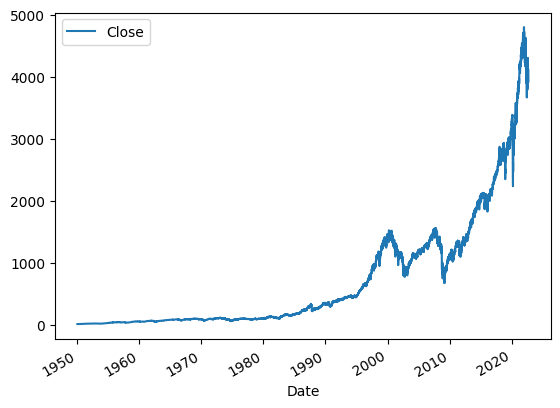

In [30]:
sp500.index = pd.to_datetime(sp500.index)
sp500.plot.line(y="Close", use_index=True)

In [31]:
del sp500["Dividends"]
del sp500["Stock Splits"]
sp500["Tomorrow"] = sp500["Close"].shift(-1)
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)
sp500 = sp500.loc["1990-01-01":].copy()

Fonctions de backtest et de prédictions (on ne peut pas faire de validation croisée car les données sont des données temporelles et le résultat serait  erroné)

In [32]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >=.6] = 1
    preds[preds <.6] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    
    return pd.concat(all_predictions)

Premier modèle : Random forest classifier

In [33]:
def model_RFC(sp500):
    horizons = [2,5,60,250,1000]
    new_predictors = []

    for horizon in horizons:
        rolling_averages = sp500.rolling(horizon).mean()
        
        ratio_column = f"Close_Ratio_{horizon}"
        sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
        
        trend_column = f"Trend_{horizon}"
        sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
        
        new_predictors+= [ratio_column, trend_column]
    
    
    sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])
    model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)
    time_RFC_start = time.time()
    predictions = backtest(sp500, model, new_predictors)
    time_RFC_end = time.time() - time_RFC_start
    accuracy = accuracy_score(predictions["Target"], predictions["Predictions"])
    precision = precision_score(predictions["Target"], predictions["Predictions"], average='weighted')
    recall = recall_score(predictions["Target"], predictions["Predictions"], average='weighted')
    f1 = f1_score(predictions["Target"], predictions["Predictions"], average='weighted')
    print(f"Exactitude : {accuracy}")
    print(f"Précision : {precision}")
    print(f"Rappel : {recall}")
    print(f"F1-mesure : {f1}")
    print(f"Temps backtest : {time_RFC_end}")
    #predictions.plot()
    


Deuxième modèle: XGboost

In [34]:
def model_XG(sp500):
    horizons = [2, 5, 60, 250, 1000]
    new_predictors = []

    for horizon in horizons:
        rolling_averages = sp500.rolling(horizon).mean()
        
        ratio_column = f"Close_Ratio_{horizon}"
        sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]
        
        trend_column = f"Trend_{horizon}"
        sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]
        
        new_predictors += [ratio_column, trend_column]
        
    
    sp500 = sp500.dropna(subset=sp500.columns[sp500.columns != "Tomorrow"])
    model = XGBClassifier(n_estimators=200, min_child_weight=50, random_state=1)
    time_XG_start = time.time()
    predictions = backtest(sp500, model, new_predictors)
    time_XG_end = time.time() - time_XG_start

    accuracy = accuracy_score(predictions["Target"], predictions["Predictions"])
    precision = precision_score(predictions["Target"], predictions["Predictions"], average='weighted')
    recall = recall_score(predictions["Target"], predictions["Predictions"], average='weighted')
    f1 = f1_score(predictions["Target"], predictions["Predictions"], average='weighted')
    print(f"Exactitude : {accuracy}")
    print(f"Précision : {precision}")
    print(f"Rappel : {recall}")
    print(f"F1-mesure : {f1}")
    print(f"Temps backtest : {time_XG_end}")
    
    #predictions.plot()

In [35]:
print("Modèle RandomForest: ")
model_RFC(sp500)



Modèle RandomForest: 
Exactitude : 0.4769945124525116
Précision : 0.5193135045173146
Rappel : 0.4769945124525116
F1-mesure : 0.41628329314750157
Temps backtest : 112.24589204788208


In [36]:
print("Modèle Xgboost: ")
model_XG(sp500)


Modèle Xgboost: 
Exactitude : 0.4938792739552554
Précision : 0.5126909427010174
Rappel : 0.4938792739552554
F1-mesure : 0.48435167966593023
Temps backtest : 5.712550401687622
